# Dad Jokes Knowledge Base

Chosen Dataset:
- **Source:** https://www.kaggle.com/datasets/usamabuttar/dad-jokes
- **License:** CC0: Public Domain
- (version from 2024-07-13)

PS: I also considered [this dataset](https://www.kaggle.com/datasets/oktayozturk010/reddit-dad-jokes/data) but it is larger than I wanted (i.e. the resulting file size would be too large for easily sharing).

In [1]:
import svs
import pandas as pd

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! You must set your OPENAI_API_KEY environment varaible !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import os
from dotenv import load_dotenv; load_dotenv()
assert os.environ.get('OPENAI_API_KEY')

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
)

# Step 1: Load the Knowledge Base

We'll read the data and load the KB. As part of that process, the embeddings will be queried from OpanAI and stored in the database.

Note: This is _not_ the final step; we'll do more cleaning in later steps...

In [3]:
DB_FILE_PATH = './dad_jokes.sqlite'

if os.path.exists(DB_FILE_PATH):
    os.unlink(DB_FILE_PATH)

kb = svs.KB(DB_FILE_PATH, svs.make_openai_embeddings_func())

In [4]:
df = pd.read_csv('./dad_jokes.csv')

jokes = df['joke'].str.strip()
jokes = list(jokes.unique())

len(jokes), jokes[:10]

(10548,
 ['A steak pun is a rare medium well done.',
  'They say that breakfast is the most important meal of the day. Well, not if it’s poisoned. Then the antidote becomes the most important.',
  'What do you get if you cross an angry sheep with a moody cow? An animal that’s in a baaaaad mooood.',
  'An apple a day keeps the doctor away. At least it does if you throw it hard enough.',
  'What sounds like a sneeze and is made of leather? A shoe.',
  'A man found a magic lamp with a genie that offered him three wishes. The man said, “For my first wish, I’d like to be rich.” “Okay, Rich,” said the genie. “What would you like for your second wish?”',
  'When does a joke become a dad joke? When it becomes apparent.',
  'I finally watched that documentary on clocks. It was about time.',
  'What did the sink tell the toilet? You look flushed!',
  'Why did the nose feel sad? It was always getting picked on.'])

In [5]:
%%time

with kb.bulk_add_docs() as add_doc:
    for j in jokes:
        add_doc(j)

2024-07-15 22:56:36,315 - svs.kb - INFO - starting bulk-add (as new database transaction)
2024-07-15 22:56:36,385 - svs.kb - INFO - getting 10548 document embeddings...
2024-07-15 22:58:46,857 - svs.kb - INFO - *DONE*: got 10548 document embeddings
2024-07-15 22:58:46,857 - svs.kb - INFO - invalidating cached vectors; they'll be re-built next time you `retrieve()`
2024-07-15 22:58:46,859 - svs.kb - INFO - ending bulk-add (committing the database transaction)


CPU times: user 14.3 s, sys: 2.23 s, total: 16.5 s
Wall time: 2min 10s


# Step 2: Remove "not safe for work" jokes

IMO dad jokes should be funny for _any_ audience (e.g. young kids). Also, I'd like to be able to present this work in professional contexts without anyone blushing. So we'll use semantic similarity to find-and-remove jokes that are, as they say, "not safe for work".

Also, the final file size (from Step 1) is a bit too big anyway (I want to be able to easily share the resulting file), so removing some jokes will help that too.

In [6]:
%%time

query = 'explicit sex references; sexual content or sexual jokes; also generally anything "not safe for work" (NSFW) such as racist, misogynistic, or otherwise discriminatory content'

docs = kb.retrieve(query, n=len(kb))

2024-07-15 22:58:58,934 - svs.kb - INFO - retrieving 10548 documents with query string: explicit sex references; sexual content or sexual jokes; also generally anything "not safe for work" (NSFW) such as racist, misogynistic, or otherwise discriminatory content
2024-07-15 22:58:58,937 - svs.kb - INFO - re-building cached vectors...
2024-07-15 22:58:59,996 - svs.kb - INFO - re-building cached vectors... DONE!
2024-07-15 22:59:00,232 - svs.kb - INFO - got embedding for query!
2024-07-15 22:59:00,269 - svs.kb - INFO - computed 10548 cosine similarities
2024-07-15 22:59:00,349 - svs.kb - INFO - retrieved top 10548 documents


CPU times: user 1.28 s, sys: 99.9 ms, total: 1.38 s
Wall time: 1.42 s


<Axes: >

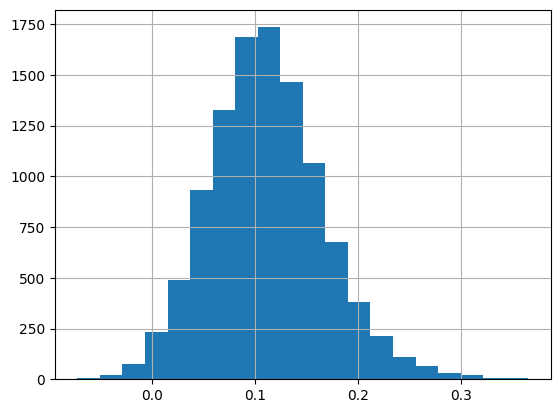

In [7]:
scores = pd.Series([doc['score'] for doc in docs])

scores.hist(bins=20)

In [8]:
scores.describe()

count    10548.000000
mean         0.111235
std          0.055459
min         -0.072688
25%          0.073623
50%          0.108523
75%          0.145078
max          0.365002
dtype: float64

In [9]:
THRESH = 0.1

(scores < THRESH).mean()

np.float64(0.434963974213121)

In [10]:
# with kb.bulk_del_docs() as del_doc:
#     for doc in sorted(docs, key = lambda doc: doc['score'], reverse=True):
#         if doc['score'] < THRESH:
#             break
#         print(f"{doc['score']:.4f}: {doc['doc']['text']}")

In [11]:
with kb.bulk_del_docs() as del_doc:
    for doc in sorted(docs, key = lambda doc: doc['score'], reverse=True):
        if doc['score'] < THRESH:
            break
        del_doc(doc['doc_id'])

2024-07-15 22:59:26,868 - svs.kb - INFO - starting bulk-delete (as new database transaction)
2024-07-15 22:59:28,867 - svs.kb - INFO - invalidating cached vectors; they'll be re-built next time you `retrieve()`
2024-07-15 22:59:28,873 - svs.kb - INFO - ending bulk-delete (committing the database transaction)


# Step 3: Remove duplicates

We'll look at documents' pairwise semantic similarity scores to find _duplicate_ jokes! I don't want duplicate jokes!

2024-07-15 22:59:30,611 - svs.kb - INFO - re-building cached vectors...
2024-07-15 22:59:31,097 - svs.kb - INFO - re-building cached vectors... DONE!
2024-07-15 22:59:31,097 - svs.kb - INFO - computing pairwise similarity over 4588 documents
2024-07-15 22:59:31,407 - svs.kb - INFO - computed 21049744 pairwise cosine similarities
2024-07-15 22:59:31,437 - svs.kb - INFO - retrieved top 10000 document pairs


<Axes: >

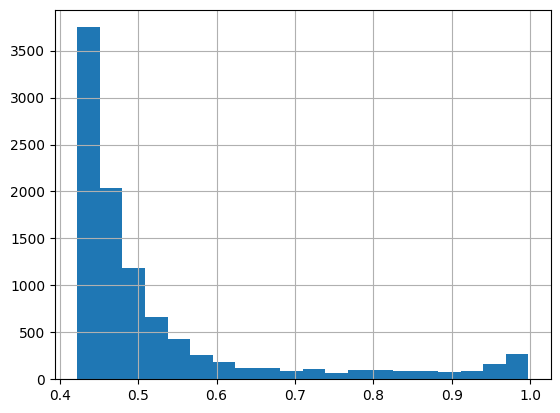

In [12]:
pairwise_scores = kb.document_top_pairwise_scores(n=10_000)

scores = pd.Series([score for score, _, _ in pairwise_scores])

scores.hist(bins=20)

In [13]:
for score, doc_1, doc_2 in pairwise_scores:
    if score < 0.9952:
        break
    print(f'!!! {score:.4f} !!!')
    print(f"> {doc_1['text']}")
    print(f"> {doc_2['text']}")
    print()

!!! 0.9976 !!!
> Did you hear about the guy who invented the knock-knock joke? He won the 'no-bell' prize.'
> Did you hear about the guy who invented the knock-knock joke? He won the 'no-bell' prize.

!!! 0.9970 !!!
> A cop started crying while he was writing me a ticket. I asked him why and he said, "It's a moving violation."
> A cop started crying while he was writing me a ticket. I asked him why and he said, 'It's a moving violation.'

!!! 0.9970 !!!
> My ex and I had a very amicable divorce. I know this because when I posted on Facebook, 'I’m getting a divorce,' she was the first one to like it.
> My ex and I had a very amicable divorce. I know this because when I posted on Facebook, “I’m getting a divorce,” she was the first one to like it.

!!! 0.9964 !!!
> A panic-stricken man explained to his doctor, “You have to help me, I think I’m shrinking.” “Now settle down,” the doctor calmly told him. “You'll just have to learn to be a little patient.”
> A panic-stricken man explained to

In [14]:
for score, doc_1, doc_2 in pairwise_scores:
    if score > 0.8:
        continue
    if score < 0.795:
        break
    print(f'!!! {score:.4f} !!!')
    print(f"> {doc_1['text']}")
    print(f"> {doc_2['text']}")
    print()

!!! 0.7995 !!!
> I decided to remove my racing snail's shell to make him go faster. But if anything, it just made him more sluggish.
> I pulled the shell off of my snail to make him faster Turned out it had the opposite effect, now he's a little sluggish.

!!! 0.7994 !!!
> What’s the difference between an African elephant and an Indian elephant? About 5,000 miles.
> What's the difference between an Indian and African elephant? For starters, one of them is an elephant.

!!! 0.7993 !!!
> It was a baby mosquito's first day to fly out from home. When the mosquito came back home later that day, the father mosquito asked, "How was your journey?"The baby mosquito replied, "It went great, everyone was clapping for me!"
> A young mosquito returned to its mother. How was your flight dear? asked mom.It was great mom, everyone clapped for me!

!!! 0.7993 !!!
> Which U.S. state is famous for its extra-small soft drinks? Minnesota!
> Which state gives you the smallest beverages? Minnesota.

!!! 0.79

In [15]:
for score, doc_1, doc_2 in pairwise_scores:
    if score > 0.6:
        continue
    if score < 0.599:
        break
    print(f'!!! {score:.4f} !!!')
    print(f"> {doc_1['text']}")
    print(f"> {doc_2['text']}")
    print()

!!! 0.5999 !!!
> I went to the shop to buy a foot pump for our new air bed. I was shocked by how much the price had risen since the last pump I purchased. But yer, I suppose that’s the cost of inflation.
> It used to be free to fill your tires with air now it costs $1.50! Now that's what you call inflation!

!!! 0.5999 !!!
> How many mystery writers does it take to change a lightbulb? Two. One to screw it in most of the way and another to give it a surprise twist at the end.
> How many actors does it take to change a light bulb? only one cause they don't like to share the spot light

!!! 0.5999 !!!
> What breed of dog can jump higher than buildings? Any dog, because buildings can’t jump.
> Can a kangaroo jump higher than a house? Of course. Houses can’t jump

!!! 0.5997 !!!
> A very long time ago, the ancients struggled to come up with a term for a 24 hour period. It got very late and they said "lets just call it a day".
> God thought long and hard what to name the period of time when 

In [16]:
# Um, this is actually graph problem.
#
# The correct solution would be to:
#   1. Build a graph from the edges above.
#   2. Compute the "connected components" of that graph.
#   3. For each connected component, pick one node (i.e. a joke) to keep, then delete the rest!
#
# However, the below is a dumb "good enough" solution, since I'd rather not add *yet more* complexity to this notebook.

with kb.bulk_del_docs() as del_doc:
    for score, doc_1, doc_2 in pairwise_scores:
        if score < 0.9:
            break
        try:
            del_doc(doc_2['id'])
        except KeyError:
            pass  # we must have already deleted this document in a previous iteration (possible if 3-or-more jokes are all similar)

2024-07-15 22:59:54,723 - svs.kb - INFO - starting bulk-delete (as new database transaction)
2024-07-15 22:59:54,802 - svs.kb - INFO - invalidating cached vectors; they'll be re-built next time you `retrieve()`
2024-07-15 22:59:54,804 - svs.kb - INFO - ending bulk-delete (committing the database transaction)


In [17]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! Since we deleted records from the database, it's a good practice to vacuum it. !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

kb.close(vacuum=True)

2024-07-15 22:59:57,818 - svs.kb - INFO - invalidating cached vectors; they'll be re-built next time you `retrieve()`


# Step 4: Final Sanity Check

Let's just make sure it's all still working correctly by querying some jokes!

In [18]:
kb = svs.KB(DB_FILE_PATH)
len(kb)

4213

In [19]:
%%time

kb.retrieve('pizza', n=5)

2024-07-15 23:00:05,715 - svs.kb - INFO - retrieving 5 documents with query string: pizza
2024-07-15 23:00:05,718 - svs.kb - INFO - re-building cached vectors...
2024-07-15 23:00:06,160 - svs.kb - INFO - re-building cached vectors... DONE!
2024-07-15 23:00:06,517 - svs.kb - INFO - got embedding for query!
2024-07-15 23:00:06,524 - svs.kb - INFO - computed 4213 cosine similarities
2024-07-15 23:00:06,527 - svs.kb - INFO - retrieved top 5 documents


CPU times: user 447 ms, sys: 49.6 ms, total: 496 ms
Wall time: 814 ms


[{'score': 0.4219512641429901,
  'doc_id': 9090,
  'doc': {'id': 9090,
   'parent_id': None,
   'level': 0,
   'text': 'How do you fix a broken pizza? With tomato paste.',
   'embedding': True,
   'meta': None}},
 {'score': 0.4053124785423279,
  'doc_id': 8676,
  'doc': {'id': 8676,
   'parent_id': None,
   'level': 0,
   'text': 'I ate a salad for dinner! It was mostly tomatoes and croutons.Really just one, big round crouton covered in tomato sauce. And cheese.... I had a pizza.',
   'embedding': True,
   'meta': None}},
 {'score': 0.3984290361404419,
  'doc_id': 4064,
  'doc': {'id': 4064,
   'parent_id': None,
   'level': 0,
   'text': 'My sister goes to the pizza place The pizza guy asks: "would you want me to cut your pizza in 4 or 12 pieces.She said: Please only 4, I can\'t eat 12 pieces all alone.',
   'embedding': True,
   'meta': None}},
 {'score': 0.3751755952835083,
  'doc_id': 398,
  'doc': {'id': 398,
   'parent_id': None,
   'level': 0,
   'text': "What is a guitar player

In [20]:
kb.close()

2024-07-15 23:00:18,369 - svs.kb - INFO - invalidating cached vectors; they'll be re-built next time you `retrieve()`
